In [104]:
import scipy
import jax
import jax.numpy as jnp
import numpy as np
import scipy.integrate as integrate

In [105]:
integrate.solve_ivp

<function scipy.integrate._ivp.ivp.solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, args=None, **options)>

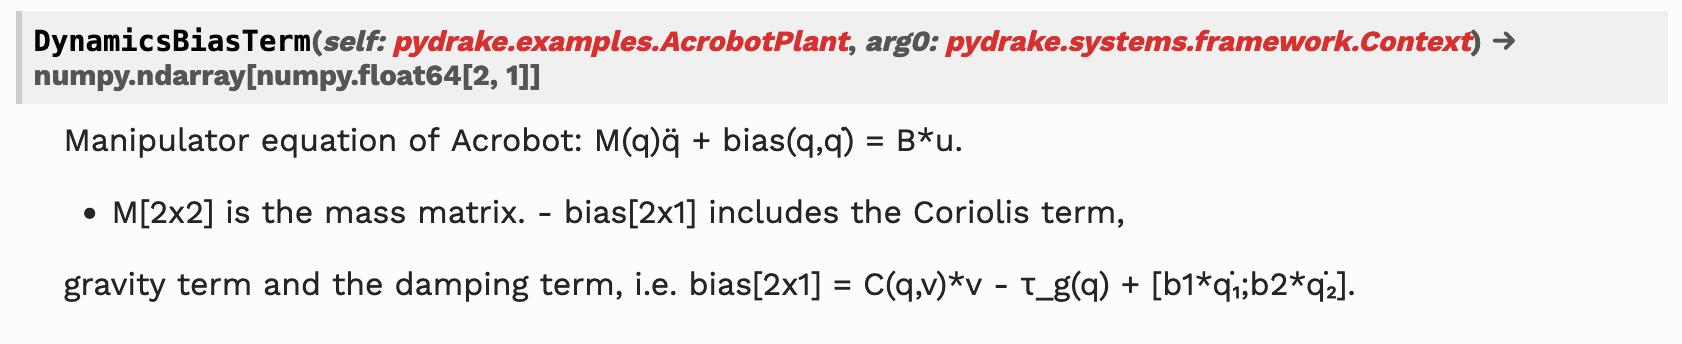

In [123]:
# Initiate the parameter like these
# https://drake.mit.edu/pydrake/pydrake.examples.html#pydrake.examples.AcrobotParams
m1 = 1
l1 = 1
lc1 = l1/2
Ic1 = 0.083
b1 = 0

m2 = 1
l2 = 2
lc2 = l2/2
Ic2 = 0.083
b2 = 0

g = 9.81

c = lambda θ: np.cos(θ)
s = lambda θ: np.sin(θ)

def unpack_x(x):
    # θ1, θ2, dθ1, dθ2 = x.flatten()
    # θ1  = x[0]
    # θ2  = x[1]
    # dθ1 = x[2]
    # dθ2 = x[3]
    return x #θ1, θ2, dθ1, dθ2
    

def M(x):
    θ1, θ2, dθ1, dθ2 = unpack_x(x)
    return np.array(
        [
            [Ic1 + Ic2 + m2*l1**2 + 2*m2*l1*lc2*c(θ1), Ic2 + m2*l1*lc2*c(θ2)],
            [Ic2 + m2*l1*lc2*c(θ2), Ic2 ]
         ]
    )

def C(x):
    θ1, θ2, dθ1, dθ2 = unpack_x(x)
    return np.array(
        [
            [-2*m2*l1*lc2*s(θ2)*dθ2, -m2*l1*lc2*s(θ2)*dθ2],
            [m2*l1*lc2*c(θ2)*dθ1, 0 ]
         ]
    )

D = np.array([[b1, 0],[0, b2]])

def τ_g(x):
    θ1, θ2, dθ1, dθ2 = unpack_x(x)
    return np.array(
        [
            [-m1*g*lc1*s(θ1)-m2*g*(l1*s(θ1)+lc2*s(θ1+θ2))],
            [-m2*g*lc2*s(θ1+θ2)]
         ]
    )

# def γ(x):
#     θ1, θ2, dθ1, dθ2 = unpack_x(x)
#     return np.array([[b1*dθ1],[b2*dθ2]])
    

def bias(x):
    θ1, θ2, dθ1, dθ2 = unpack_x(x)
    return (
        C(x) @ np.array([[θ1],[θ1]]) - τ_g(x)
        + γ(x)
    )
    
B = np.array([[0],[1]])

Ω = lambda x: np.block([
    [np.eye(2), 0*np.eye(2)],
    [C(x)+D, M(x)]
])

def dynamics(t, x, u=0): #ivp always expect t to be the first argument
    θ1, θ2, dθ1, dθ2 = unpack_x(x)
    return (
        np.linalg.inv(Ω(x)) @ np.block([dθ1,
                                        dθ2,
                                        (τ_g(x) + B * u).flatten()
                                       ])
    )


In [124]:
x0 = np.array([np.pi/2,np.pi/2,0,0])

t_span = (0,3)

integrate.solve_ivp(dynamics, t_span, [np.pi/2,np.pi/2,0,0], args=(0,))

  message: Required step size is less than spacing between numbers.
  success: False
   status: -1
        t: [ 0.000e+00  7.355e-05 ...  4.020e-01  4.020e-01]
        y: [[ 1.571e+00  1.571e+00 ...  7.109e-01  7.109e-01]
            [ 1.571e+00  1.571e+00 ...  1.171e+00  1.171e+00]
            [ 0.000e+00 -9.994e-04 ...  7.282e+03  1.070e+04]
            [ 0.000e+00  9.994e-04 ... -4.141e+04 -6.085e+04]]
      sol: None
 t_events: None
 y_events: None
     nfev: 494
     njev: 0
      nlu: 0

In [96]:
C(np.array([[0,0,0,0]]))

array([[-0., -0.],
       [ 0.,  0.]])

In [97]:
np.linalg.inv(Ω(np.array([[0,np.pi/2,0,0.1]]).T))

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.03243594,  0.06487188,  0.32435939, -0.32435939],
       [-0.03243594, -1.26969116, -0.32435939, 12.37255216]])

In [98]:
dynamics(np.array([[0,np.pi/2,0,0]]), 0)

array([ 0.00000000e+00,  0.00000000e+00,  1.77635684e-15, -1.18192771e+02])

In [76]:
τ_g(np.array([[0,np.pi/2,0,0]])) + B

array([[-9.81],
       [-8.81]])

In [88]:
np.block([0,
          0,
         (τ_g(np.array([[0,np.pi/2,0,0]])) + B)[:,0]
         ],)

array([ 0.  ,  0.  , -9.81, -8.81])

In [85]:
(τ_g(np.array([[0,np.pi/2,0,0]])) + B)[:,0].T

array([-9.81, -8.81])